# BSGP model Tutorial

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import  TensorDataset
import matplotlib.pyplot as plt 
import seaborn as sns
import gpflow
import tensorflow_probability as tfp
import tensorflow as tf
import scipy
import process_results

2023-08-07 22:52:15.592863: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
def libsvm_to_pth(path, name):
    df = pd.read_csv(path, delimiter=' ', header=None)
    columns_to_clean = df.columns[2:]
    df[columns_to_clean] = df[columns_to_clean].applymap(lambda x: x.split(":")[1])
    df.drop(df.columns[1], axis=1, inplace=True)
    X = np.atleast_2d(df[list(df.columns)[1:]].to_numpy().astype(float))
    Y = df[0].to_numpy().reshape(-1,1)
    Y[Y == 2] = 0
    Y[Y == 4] = 1
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    inputs = torch.tensor(X, dtype=torch.float64)
    targets = torch.tensor(Y, dtype=torch.float64)
    torch.save([inputs, targets], 'data/' + name + '.pth')
    
def csv_to_pth(name, csv_path, pth_path, header=None, clf=False):
    def dataframe_to_arrays(df):
        df_ = df.copy(deep=True)
        X = np.atleast_2d(df_[input_cols].to_numpy())
        Y = np.atleast_2d(df_[output_cols].to_numpy().reshape(-1,1))
        return X, Y
    dataframe_raw = pd.read_csv(csv_path, delimiter=' ', header=header)
    dataframe_raw.head()
    dataframe_raw.replace('?', float('nan'), inplace=True)
    dataframe_raw = dataframe_raw.apply(pd.to_numeric, errors='coerce')
    dataframe_raw.fillna(dataframe_raw.mean(), inplace=True)
    input_cols = list(dataframe_raw.columns)[:-1]
    output_cols = list(dataframe_raw.columns)[-1]
    X, Y = dataframe_to_arrays(dataframe_raw)
    Y[Y>0] = 1 if clf else None
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    inputs = torch.tensor(X, dtype=torch.float64)
    targets = torch.tensor(Y, dtype=torch.float64)
    torch.save([inputs, targets], pth_path + name + '.pth')
    return input_cols, output_cols
#input_cols, output_cols = csv_to_pth("breast", "data/breast_cancer.txt", "data/", clf=True)

In [4]:
def create_dataset(dataset, static, fold):
    dataset_path = ('./data/' + dataset + '.pth')
    dataset = TensorDataset(*torch.load(dataset_path))
    X, Y = dataset.tensors
    X, Y = X.numpy(), Y.numpy()

    if static == False:
        Y_mean, Y_std = Y.mean(0), Y.std(0) + 1e-9
        #Y = (Y - Y_mean) / Y_std
        return X, Y, Y_mean, Y_std
    else:
        #X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=fold)
        X_train_indices_boolean = np.random.choice([1, 0], size=X.shape[0], p=[0.8, 0.2])
        X_train_indices = np.where(X_train_indices_boolean == 1)[0]
        X_test_indices = np.where(X_train_indices_boolean == 0)[0]
        X_train = X[X_train_indices]
        Y_train = Y[X_train_indices]
        X_test = X[X_test_indices]
        Y_test = Y[X_test_indices]
        Y_train_mean, Y_train_std = Y_train.mean(0), Y_train.std(0) + 1e-9
        #Y_train = (Y_train - Y_train_mean) / Y_train_std
        #Y_test = (Y_test - Y_train_mean) / Y_train_std
        return X_train, Y_train, X_test, Y_test, Y_train_mean, Y_train_std, X_train_indices, X_test_indices

In [73]:
X, Y, Y_mean, Y_std = create_dataset('breast', False, 0)

In [74]:
X.shape

(683, 10)

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=12)
X_pca_12 = pca.fit_transform(X)
inputs = torch.tensor(X_pca_12, dtype=torch.float64)
targets = torch.tensor(Y, dtype=torch.float64)
torch.save([inputs, targets], 'data/credit_pca_12.pth')

## GPFlow Classification with RBF-AID kernel

In [3]:
def get_lower_triangular_from_diag(d):
    """
    diag: diagonal of lengthscales parameter [D,]
    ---
    Σ=inv(Λ) -> diagonal matrix with lengthscales on the diagonal (RBF)
    The diagonal of Λ is obtained as 1/(l^2), l is a lengthscale
    returns: L, Λ=LLᵀ
    """
    # Define the lengthscales according to the standard RBF kernel
    lengthscales = np.full((d,), d**0.5, dtype=np.float64) # lengthscales = tf.constant([d**0.5]*d, dtype=tf.float64)
    # Obtain the matrix L such that LLᵀ=Λ and Λ=inv(diag(lengthscales))
    Lambda = np.diag(1/(lengthscales**2)) # Lambda = tf.linalg.diag(1/(lengthscales**2))
    L = scipy.linalg.cholesky(Lambda, lower=True) # L = Cholesky(inv(diag(lengthscales)))
    return tfp.math.fill_triangular_inverse(L, upper=False) 
class Kernel(object):
    """
    The basic kernel class. Handles input_dim and active dims, and provides a
    generic '_slice' function to implement them.
    """

    def __init__(self, input_dim, active_dims=None, name=None):
        """
        input dim is an integer
        active dims is either an iterable of integers or None.
        Input dim is the number of input dimensions to the kernel. If the
        kernel is computed on a matrix X which has more columns than input_dim,
        then by default, only the first input_dim columns are used. If
        different columns are required, then they may be specified by
        active_dims.
        If active dims is None, it effectively defaults to range(input_dim),
        but we store it as a slice for efficiency.
        """
        self.input_dim = int(input_dim)
        if active_dims is None:
            self.active_dims = slice(input_dim)
        elif isinstance(active_dims, slice):
            self.active_dims = active_dims
            if active_dims.start is not None and active_dims.stop is not None and active_dims.step is not None:
                assert len(range(active_dims.start, active_dims.stop, active_dims.step)) == input_dim
        else:
            self.active_dims = np.array(active_dims, dtype=np.int32)
            assert len(active_dims) == input_dim

    def _validate_ard_shape(self, name, value, ARD=None):
        """
        Validates the shape of a potentially ARD hyperparameter
        :param name: The name of the parameter (used for error messages)
        :param value: A scalar or an array.
        :param ARD: None, False, or True. If None, infers ARD from shape of value.
        :return: Tuple (value, ARD), where _value_ is a scalar if input_dim==1 or not ARD, array otherwise.
            The _ARD_ is False if input_dim==1 or not ARD, True otherwise.
        """
        if ARD is None:
            ARD = np.asarray(value).squeeze().shape != ()

        if ARD:
            # accept float or array:
            value = value * np.ones(self.input_dim, dtype=float)

        if self.input_dim == 1 or not ARD:
            correct_shape = ()
        else:
            correct_shape = (self.input_dim,)

        if np.asarray(value).squeeze().shape != correct_shape:
            raise ValueError("shape of {} does not match input_dim".format(name))

        return value, ARD

    def compute_K(self, X, Z):
        return self.K(X, Z)

    def compute_K_symm(self, X):
        return self.K(X)

    def compute_Kdiag(self, X):
        return self.Kdiag(X)

    def on_separate_dims(self, other_kernel):
        """
        Checks if the dimensions, over which the kernels are specified, overlap.
        Returns True if they are defined on different/separate dimensions and False otherwise.
        """
        if isinstance(self.active_dims, slice) or isinstance(other_kernel.active_dims, slice):
            # Be very conservative for kernels defined over slices of dimensions
            return False

        if np.any(self.active_dims.reshape(-1, 1) == other_kernel.active_dims.reshape(1, -1)):
            return False

        return True

    def _slice(self, X, X2):
        """
        Slice the correct dimensions for use in the kernel, as indicated by
        `self.active_dims`.
        :param X: Input 1 (NxD).
        :param X2: Input 2 (MxD), may be None.
        :return: Sliced X, X2, (Nxself.input_dim).
        """
        if isinstance(self.active_dims, slice):
            X = X[..., self.active_dims]
            if X2 is not None:
                X2 = X2[..., self.active_dims]
        else:
            X = tf.gather(X, self.active_dims, axis=-1)
            if X2 is not None:
                X2 = tf.gather(X2, self.active_dims, axis=-1)

        input_dim_shape = tf.shape(X)[-1]
        input_dim = tf.convert_to_tensor(self.input_dim, dtype=tf.int32)
        with tf.control_dependencies([tf.assert_equal(input_dim_shape, input_dim)]):
            X = tf.identity(X)

        return X, X2

    def _slice_cov(self, cov):
        """
        Slice the correct dimensions for use in the kernel, as indicated by
        `self.active_dims` for covariance matrices. This requires slicing the
        rows *and* columns. This will also turn flattened diagonal
        matrices into a tensor of full diagonal matrices.
        :param cov: Tensor of covariance matrices (NxDxD or NxD).
        :return: N x self.input_dim x self.input_dim.
        """
        cov = tf.cond(tf.equal(tf.rank(cov), 2), lambda: tf.matrix_diag(cov), lambda: cov)

        if isinstance(self.active_dims, slice):
            cov = cov[..., self.active_dims, self.active_dims]
        else:
            cov_shape = tf.shape(cov)
            covr = tf.reshape(cov, [-1, cov_shape[-1], cov_shape[-1]])
            gather1 = tf.gather(tf.transpose(covr, [2, 1, 0]), self.active_dims)
            gather2 = tf.gather(tf.transpose(gather1, [1, 0, 2]), self.active_dims)
            cov = tf.reshape(tf.transpose(gather2, [2, 0, 1]),
                             tf.concat([cov_shape[:-2], [len(self.active_dims), len(self.active_dims)]], 0))
        return cov

class FullPrecisionRBF(gpflow.kernels.Kernel):  

    def __init__(self, **kwargs):
        randomized = kwargs["randomized"]
        self.d = kwargs["d"]
        self.prior_precision_info = kwargs["prior_precision_info"]
        self._v = kwargs["variance"]
        if not randomized:
            L = get_lower_triangular_from_diag(self.d)
        super().__init__()
        self.L = tf.Variable(L, name='L', dtype=tf.float64)
        self.logvariance = tf.Variable(np.log(self._v), dtype=tf.float64, name='log_variance', trainable=False)
        self.variance = tf.exp(self.logvariance)

    def K(self, X, X2=None):
        """
            X: matrix NxD
            X2: matrix NxD
            ---
            Returns Kernel matrix as a 2D tensor
        """
        if X2 is None:
            X2 = X
        N1 = tf.squeeze(tf.shape(X)[:-1])
        N2 = tf.squeeze(tf.shape(X2)[:-1])
        Lambda = self.precision() # recover UᵀU

        # compute z, z2
        z = self._z(X, Lambda) # N1x1 array
        z2 = self._z(X2, Lambda) # N2x1 array
        # compute X(X2Λ)ᵀ
        X2Lambda = tf.linalg.matmul(X2, Lambda)
        XX2LambdaT = tf.linalg.matmul(X, tf.transpose(X2Lambda)) # N1xN2 matrix
        # compute z1ᵀ 
        ones_N2 = tf.ones(shape=(N2,1), dtype=tf.float64) # N2x1 array
        zcol = tf.linalg.matmul(z, tf.transpose(ones_N2)) # N1xN2 matrix
        # compute 1z2ᵀ 
        ones_N1 = tf.ones(shape=(N1,1), dtype=tf.float64) # N1x1 array
        zrow = tf.linalg.matmul(ones_N1, tf.transpose(z2)) # N1xN2 matrix

        exp_arg = zcol - 2*XX2LambdaT + zrow
        Kxx = tf.math.exp(-0.5 * exp_arg)
        return self.variance * Kxx
    
    def K_diag(self, X):
        return tf.fill(tf.shape(X)[:-1], tf.squeeze(self.variance))
    
    def _z(self, X, Lambda):
        XLambda = tf.linalg.matmul(X, Lambda)
        XLambdaX = tf.math.multiply(XLambda, X)
        return tf.math.reduce_sum(XLambdaX, axis=1, keepdims=True)
    
    def precision(self):
        L = tfp.math.fill_triangular(self.L, upper=False) # recover L matrix from L array
        Lambda = tf.linalg.matmul(L, tf.transpose(L))
        return Lambda
    
    def precision_off_diagonals(self):
        diag_L = tf.linalg.tensor_diag_part(self.precision())
        return self.precision() - tf.linalg.diag(diag_L)
    
    def precision_off_diagonals_prot(self):
        return tf.boolean_mask(self.precision(), ~tf.eye(self.d, self.d, dtype=tf.bool))
    
    def __str__(self):
        Lambda = self.precision()
        return 'Variance: {}\nLambda: {}'.format(self.variance, Lambda)
    def __str__(self):
        if self.prior_precision_info['type'] is not None:
            prior_precision_info_str = ' Prior precision type = %s'%(self.prior_precision_info['type'])
            if self.prior_precision_info['type'] == 'laplace' or self.prior_precision_info['type'] == 'laplace-diagnormal':
                prior_precision_info_str +=  ' (b = %.2f)'%self.prior_precision_info['hparams']
        else:
            prior_precision_info_str = ' Prior precision type = None' 
        str = [
            '======= Kernel: FullPrecisionRBF (param: LLᵀ)',
            # ' Input dim = %d' % self.input_dim,
            ' Variance = %.3f' % self._v,
            prior_precision_info_str
        ]
        return '\n'.join(str)

In [16]:
prior_precision_info = {'type': None, 'hparams': 0.01}
kernel = FullPrecisionRBF(variance=0.1, randomized=False, d=24, prior_precision_info=prior_precision_info) 
M = 100
Z = X_train[:M, :].copy()
N = X_train.shape[0]
model = gpflow.models.SVGP(
    kernel=kernel,
    likelihood=gpflow.likelihoods.Bernoulli(),
    inducing_variable=Z,
    num_data=N
)
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss_closure((X_train, Y_train)), model.trainable_variables)
gpflow.utilities.print_summary(model, "notebook")

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.L,ResourceVariable,,,True,"(300,)",float64,"[0.0000e+00, -1.4000e-04, -1.0000e-05..."
SVGP.kernel.logvariance,ResourceVariable,,,False,(),float64,-2.30259
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(100, 24)",float64,"[[-0.85432, -1.4196, 1.708..."
SVGP.q_mu,Parameter,Identity,,True,"(100, 1)",float64,[[-4.59911e+00...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 100, 100)",float64,"[[[7.1178e-01, 0.0000e+00, 0.0000e+00..."


In [35]:
Fsamples = model.predict_f_samples(X_test).numpy().squeeze().T
Psamples = model.likelihood.invlink(Fsamples)
Y_pred = np.array([int(i) for i in Psamples >= 0.5]).reshape(-1,1)
np.sum(Y_pred  ==  Y_test) / Y_pred.shape[0]

## BSGP-AID classification 

In [4]:
processed_results = process_results.process_results_onefold(filepath='results/run-0002/eeg_AID_results.json')

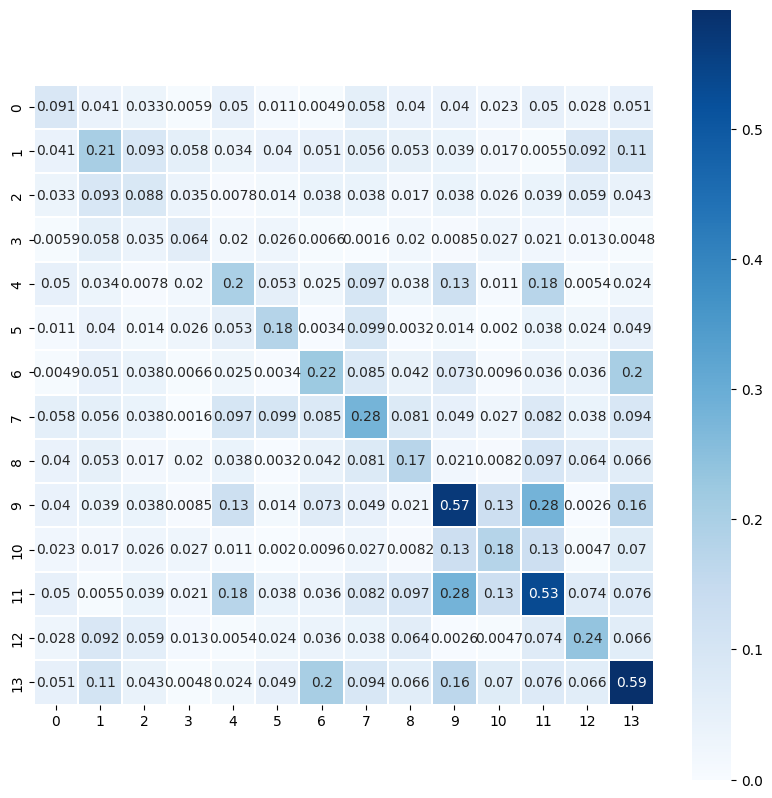

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
max = np.max(np.abs(processed_results['precisions_merged_mean']))
sns.heatmap(np.abs(processed_results['precisions_merged_mean']), annot=True, square=True, cmap='Blues', vmax=max, vmin=0, center=max/2., linewidth=.3, ax=ax)
plt.show()

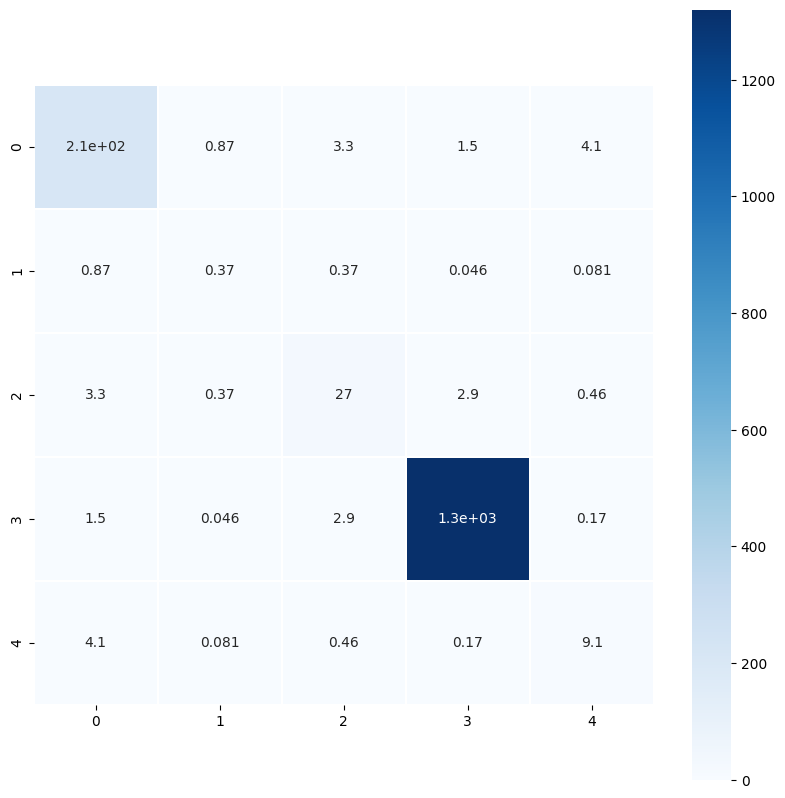

In [6]:
processed_results = process_results.process_results_kfold(filepath='results/run-0001/wilt_AID_results.json')
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
max = np.max(np.abs(processed_results['precisions_merged_mean_kfold'][0]))
sns.heatmap(np.abs(processed_results['precisions_merged_mean_kfold'][0]), annot=True, square=True, cmap='Blues', vmax=max, vmin=0, center=max/2., linewidth=.3, ax=ax)
plt.show()